In [1]:
import pandas as pd
from tqdm.notebook import tqdm

In [9]:
from src.lichess_decorate import ext_trepo, fixt_trepo, proc_drop, export_dir

In [ ]:
#ext_trepo.purge()

#proc_drop(
#    next(fixt_trepo.dfs).loc[
#        lambda df: df["tournamentId"].isin(df["tournamentId"].unique()[:10]), :
#    ]
#)

In [3]:
ext_trepo.purge()
for e in tqdm(fixt_trepo.map_partitions(proc_drop, workers=5), desc="main"):
    pass

main: 0it [00:00, ?it/s]

In [ ]:
# proc_drop(next(fixt_trepo.dfs).head(10_000))

In [4]:
decorated_fixture_df = next(ext_trepo.dfs)

In [5]:
tid = "tournamentId"
uid = "UserId"
_tid = decorated_fixture_df[tid].unique()[3]
url = f"https://lichess.org/tournament/{_tid}"
print(url)
_tdf = decorated_fixture_df.loc[lambda df: df[tid] == _tid].sort_values(
    "current_points", ascending=False
)
_tdf.drop_duplicates(uid, keep="first").loc[
    :, [uid, "current_points"]
].assign(
    ps=lambda df: _tdf.groupby("UserId")["points_won"]
    .agg(lambda s: s.astype(str).sum()[::-1])
    .reindex(df[uid]).values
).head(10)

https://lichess.org/tournament/0YW9w4U7


,UserId,current_points,ps
17657,gunlapat,32,203254042244
17456,RasimQasim,30,30324033444
17540,Zhadaev_Vadim,28,22444444
17617,AM_TITAN_IR,27,1335500033301
17040,OrangutanZR,25,023444404
17332,Milenaoxanova,25,320422444
17641,BudapestoSauce,24,022244400042
16794,maverickzw,24,2244440004
17396,SHAFAR16,24,220224444
17159,dGonzo,24,22444022004


In [6]:
xy = ["elo_diff_rate", "stage_of_tournament"]

In [7]:
xy = ["overachievement_rate", "stage_of_tournament"]

In [8]:
decorated_fixture_df.pipe(
    lambda df: df.assign(**{k: pd.qcut(df[k].round(2).values, 5) for k in xy})
).assign(
    Win=lambda df: df["Result"] == "1-0",
    berzerkWin=lambda df: df["Win"] & df["did_berzerk"],
).groupby(
    xy[::-1]
).agg(
    count=pd.NamedAgg("UserId", "count"),
    berzerkRate=pd.NamedAgg("did_berzerk", "mean"),
    winRate=pd.NamedAgg("Win", "mean"),
    berzerkAndWin=pd.NamedAgg("berzerkWin", "mean"),
).assign(
    berzerkWinRate=lambda df: df["berzerkAndWin"] / df["berzerkRate"]
).style.background_gradient()  # .pivot_table(index=xy[0], columns=xy[0], values="didBerzerk")

/tmp/ipykernel_412757/989400996.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ).groupby(


In [8]:
decorated_fixture_df.pipe(
    lambda df: df.assign(**{k: pd.qcut(df[k].round(2).values, 5) for k in xy})
).assign(
    Win=lambda df: df["Result"] == "1-0",
    berzerkWin=lambda df: df["Win"] & df["did_berzerk"],
).groupby(
    xy[::-1]
).agg(
    count=pd.NamedAgg("UserId", "count"),
    berzerkRate=pd.NamedAgg("did_berzerk", "mean"),
    winRate=pd.NamedAgg("Win", "mean"),
    berzerkAndWin=pd.NamedAgg("berzerkWin", "mean"),
).assign(
    berzerkWinRate=lambda df: df["berzerkAndWin"] / df["berzerkRate"]
).style.background_gradient()  # .pivot_table(index=xy[0], columns=xy[0], values="didBerzerk")

/tmp/ipykernel_163507/989400996.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ).groupby(


In [ ]:
ex

<Axes: >

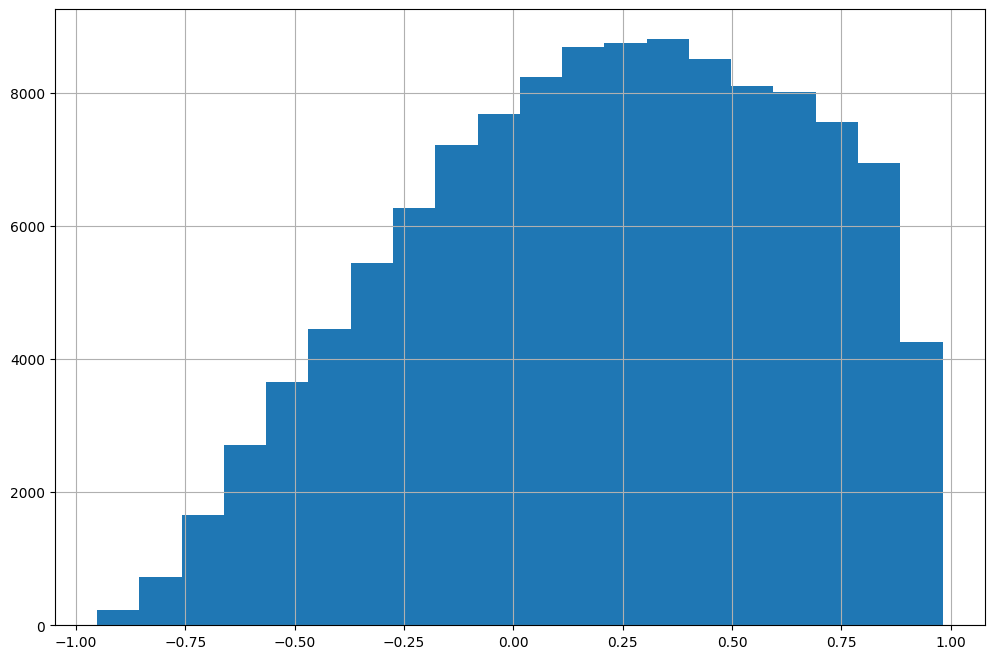

In [18]:
decorated_fixture_df.loc[lambda df: df["stage_of_tournament"] > 0.4, "overachievement_rate"].hist(bins=20, figsize=(12,8))

<Axes: >

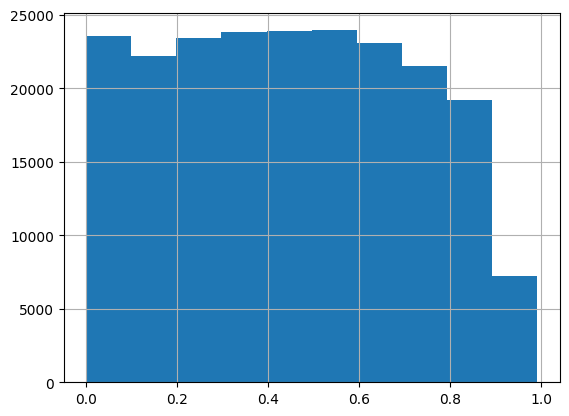

In [11]:
decorated_fixture_df["stage_of_tournament"].hist()

In [21]:
dec_csv_dir = export_dir / "decorated-csvs"
dec_csv_dir.mkdir(exist_ok=True)

for dec_df in tqdm(ext_trepo.dfs):
    dec_df.to_csv(dec_csv_dir / f'{dec_df["tournament_week"].iloc[0]}.csv.gz', index=False)

0it [00:00, ?it/s]

In [22]:
dec_df

,tournamentId,stamp,termination,UserId,OppId,Elo,OppElo,Result,result,startTime,...,opposition_points_won,opposition_current_points,opposition_performance_rating,opposition_current_position_based_on_points,opposition_current_position_based_on_points_and_pr,opposition_initial_position_based_on_elo,opposition_so_far_termination_rules_infraction,opposition_current_rank_rate,opposition_initial_rank_rate,opposition_overachievement_rate
0,00aM6Gqv,2023-12-03 21:01:11,normal,gta2012,magnakadingjjpr,1754.0,1752.0,1-0,win,180.0,...,0,0,1354.000000,38,60.0,395.0,0,0.068886,0.453502,0.384615
1,00aM6Gqv,2023-12-03 21:01:11,normal,Zeyad_Bandery,raduclaudiu,1776.0,1800.0,0-1,lose,90.0,...,3,3,2176.000000,1,1.0,454.0,0,0.001148,0.521240,0.520092
2,00aM6Gqv,2023-12-03 21:01:11,abandoned,Nailchesss,caja007,1755.0,1757.0,0-1,lose,NaN,...,2,2,2155.000000,4,27.0,401.0,0,0.030999,0.460390,0.429392
3,00aM6Gqv,2023-12-03 21:01:11,normal,Sokol_128,adrianom1985,2068.0,2063.0,0-1,lose,180.0,...,2,2,2468.000000,4,9.0,733.0,0,0.010333,0.841561,0.831228
4,00aM6Gqv,2023-12-03 21:01:11,time_forfeit,santofrick,Masulovic,2076.0,2075.0,1-0,win,180.0,...,0,0,1676.000000,61,67.0,741.5,0,0.076923,0.851320,0.774397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167614,zrqbgZCE,2023-11-30 18:29:07,abandoned,tribunaldejusticia,martinode,1844.0,1770.0,1-0,win,180.0,...,0,0,1444.000000,1681,1838.5,1035.0,0,0.847235,0.476959,-0.370276
1167615,zrqbgZCE,2023-11-30 18:29:07,abandoned,Ferrerrosa67,Cubanauta,1597.0,1638.0,1-0,win,180.0,...,0,0,1197.000000,1681,1984.0,651.5,0,0.914286,0.300230,-0.614055
1167616,zrqbgZCE,2023-11-30 18:29:07,abandoned,Cubanauta,Ferrerrosa67,1638.0,1597.0,0-1,lose,NaN,...,2,2,2038.000000,1293,1365.0,554.5,0,0.629032,0.255530,-0.373502
1167617,zrqbgZCE,2023-11-30 18:29:07,abandoned,martinode,tribunaldejusticia,1770.0,1844.0,0-1,lose,NaN,...,2,2,2170.000000,1293,1334.5,1305.5,0,0.614977,0.601613,-0.013364


In [24]:
dec_df.shape[0] / 1e6

1.167619